began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 0.997842073441
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.8792681694
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.5687520504
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.484623909
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.38420200348
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.6853120327
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.3590528965
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.14612793922
 0

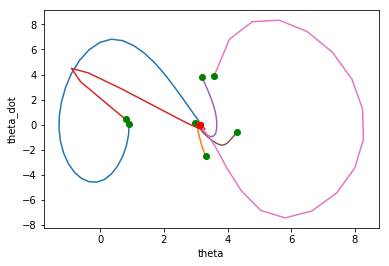

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.59083795547
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.14395618439
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.85508799553
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.86350107193
total cost:  1530.55 + ( 0.00) | 	constraint  295.03 	bad 80,  0.00 + ( 117.39)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.74959802628
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.53329896927
 1 2 3

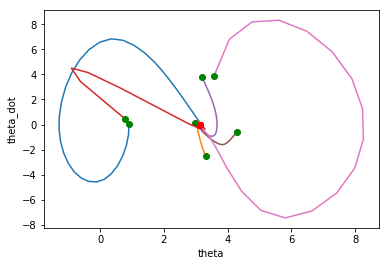

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.29354596138
total cost:  1533.83 + ( 0.00) | 	constraint  292.32 	bad 80,  0.00 + ( 115.52)
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.31892299652
FINISHED iteration!

BEFORE NN MERGE


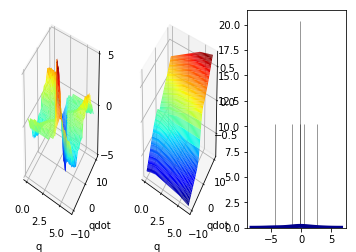

nn - vi policy deviations: avg=-0.43, std=1.97, MSE=28.55, MAE=1.36

AFTER NN MERGE


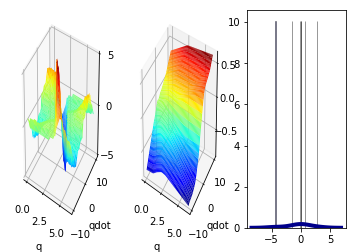

nn - vi policy deviations: avg=-0.38, std=2.00, MSE=29.09, MAE=1.34
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.55730104446
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.99705004692
 0

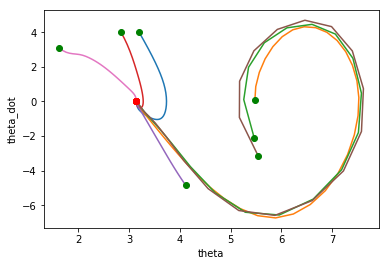

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.67232608795
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.90214681625
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.1853120327
total cost:  1221.06 + ( 0.00) | 	constraint  318.60 	bad 90,  0.00 + ( 118.15)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.08017921448
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.23515200615
 1 2 3

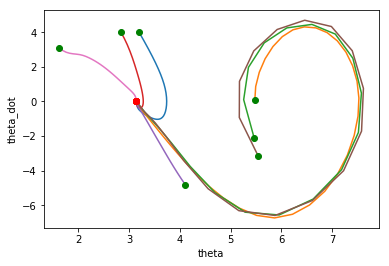

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.83813095093
total cost:  1222.84 + ( 0.00) | 	constraint  317.21 	bad 90,  0.00 + ( 117.19)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.92849612236
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.13168692589
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.46728992462
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.70486903191
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.64229106903
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.36666297913
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.58334112167
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.46201515198
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 0.740191936493
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.38740921021
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.059

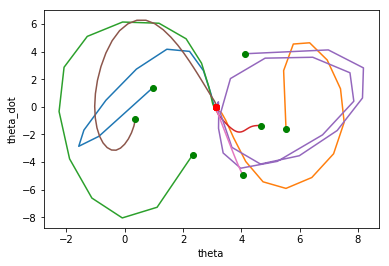

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.87117290497
total cost:  1466.65 + ( 0.00) | 	constraint  231.99 	bad 66,  0.00 + ( 79.13)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.12944102287
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.15423417091
 1 2 3

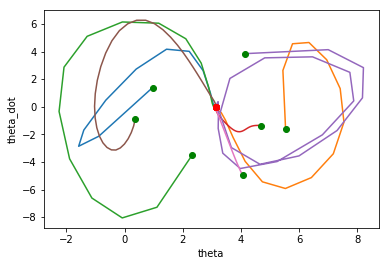

total cost:  1468.15 + ( 0.00) | 	constraint  230.44 	bad 64,  0.00 + ( 77.70)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 9.64443993568
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.34652209282
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.41834211349
 4 5 6

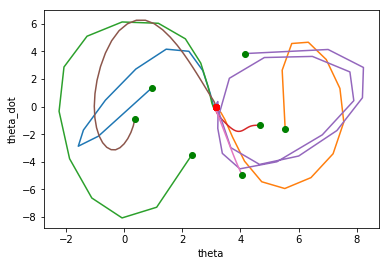

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.85489320755
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.43584012985
total cost:  1470.32 + ( 0.00) | 	constraint  228.83 	bad 64,  0.00 + ( 76.40)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.65875506401
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.48663806915
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.51246094704
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.06837892532
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.56176495552
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.15982913971
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.02678894997
 0

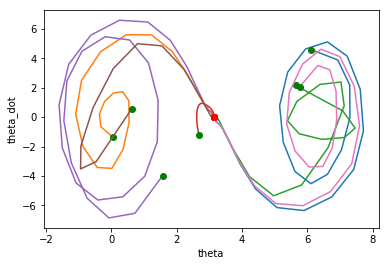

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.31657886505
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.43585896492
total cost:  1926.81 + ( 0.00) | 	constraint  200.69 	bad 56,  0.00 + ( 59.09)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.01468205452
 1 2 3

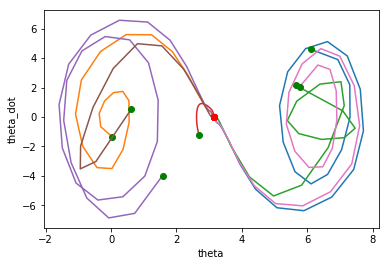

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.75228881836
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.77352190018
total cost:  1927.35 + ( 0.00) | 	constraint  199.21 	bad 56,  0.00 + ( 57.89)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.71721506119
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 8.84650301933
 4 5RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.96350002289
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.81168293953
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.86217093468
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.35746407509
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.57825899124
FINISHED iteration!

BEFORE NN MERGE


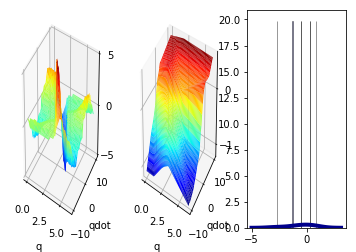

nn - vi policy deviations: avg=-0.51, std=1.12, MSE=10.66, MAE=0.95

AFTER NN MERGE


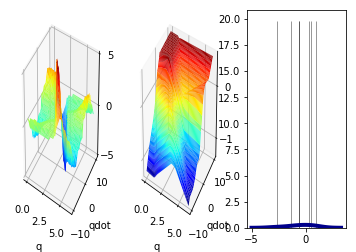

nn - vi policy deviations: avg=-0.48, std=1.15, MSE=10.86, MAE=1.00
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.48269915581
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.14185905457
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.55885791779
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.02711105347
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.6642999649
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.63592505455
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.90988206863
 0

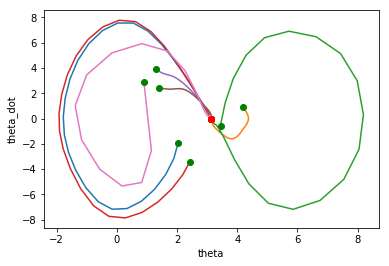

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.36242604256
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 8.89296293259
total cost:  1999.85 + ( 0.00) | 	constraint  310.57 	bad 80,  0.00 + ( 118.30)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.97474193573
 1 2 3

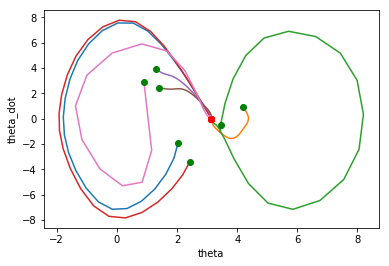

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.72486400604
total cost:  2000.92 + ( 0.00) | 	constraint  307.81 	bad 80,  0.00 + ( 115.61)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.89505887032
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.3003590107
 4 5 6

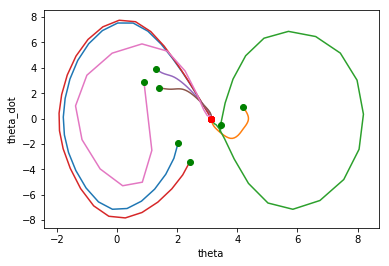

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.32886719704
total cost:  2002.88 + ( 0.00) | 	constraint  306.72 	bad 78,  0.00 + ( 114.35)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.31364512444
 7RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.42169904709
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.15995407104
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.40434908867
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.76736092567
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.82951211929
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.5218000412
 0

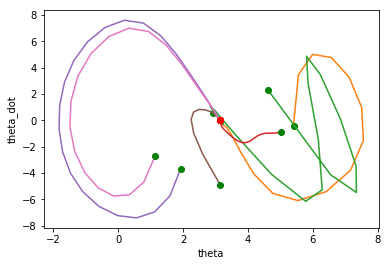

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.71751379967
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.98566198349
total cost:  2450.37 + ( 0.00) | 	constraint  228.45 	bad 58,  0.00 + ( 70.55)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.61617207527
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.84261417389
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.60292696953
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.61723804474
 1 2 3

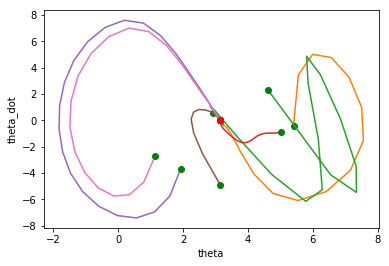

total cost:  2453.09 + ( 0.00) | 	constraint  227.96 	bad 58,  0.00 + ( 70.10)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.49663710594
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.94821715355
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.49159097672
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 12.4198641777
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.2935230732
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.9099509716
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.13374304771
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.85289812088
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.29555702209
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.59516096115
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.56698894501
 0

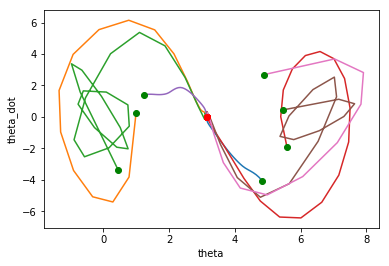

total cost:  1949.38 + ( 0.00) | 	constraint  239.61 	bad 59,  0.00 + ( 74.13)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.5911090374
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.70976090431
 1 2 3

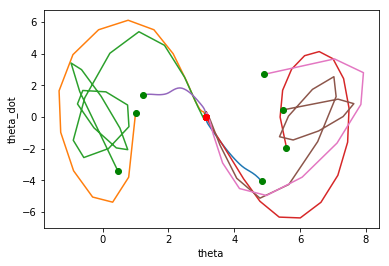

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.00025987625
total cost:  1951.54 + ( 0.00) | 	constraint  232.83 	bad 55,  0.00 + ( 68.71)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.83892583847
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.08884096146
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.0484559536
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.88003611565
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.08072400093
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.57236719131
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.54201602936
FINISHED iteration!

BEFORE NN MERGE


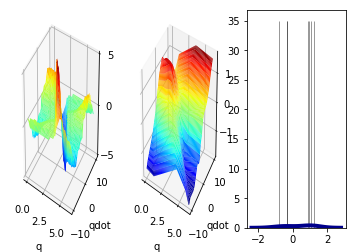

nn - vi policy deviations: avg=0.38, std=0.77, MSE=5.21, MAE=0.80

AFTER NN MERGE


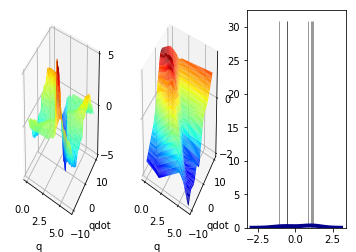

nn - vi policy deviations: avg=0.28, std=0.91, MSE=6.40, MAE=0.92
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.22688698769
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.38659310341
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.04295492172
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.68950891495
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.09883904457
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.19661808014
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.60748291016
 0

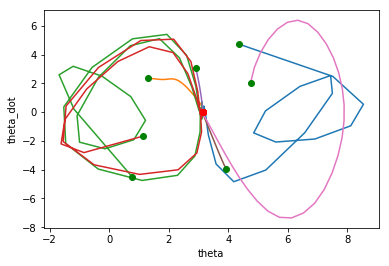

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.78810214996
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.51922917366
total cost:  1563.07 + ( 0.00) | 	constraint  284.59 	bad 82,  0.00 + ( 101.45)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.56732702255
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.62087106705
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.56003093719
 1 2 3

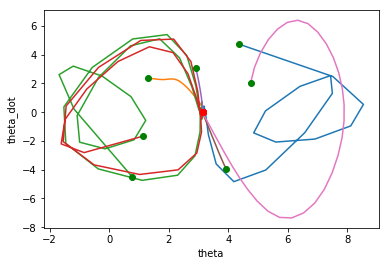

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.50115203857
total cost:  1563.28 + ( 0.00) | 	constraint  281.95 	bad 80,  0.00 + ( 99.30)
 4 5 6

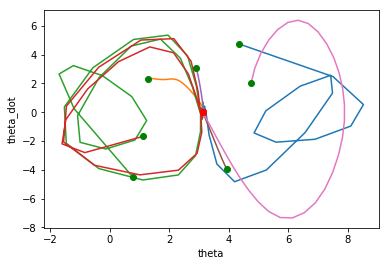

total cost:  1564.18 + ( 0.00) | 	constraint  279.11 	bad 79,  0.00 + ( 97.01)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.61784911156
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 14.8152050972
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.42055392265
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.24625110626
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.38577508926
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.52166700363
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.90618395805
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.71077895164
 0

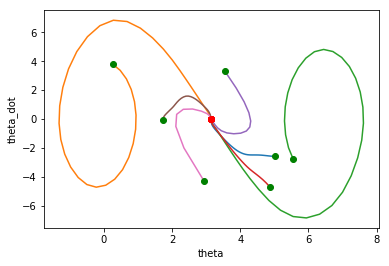

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.08628201485
total cost:  3895.13 + ( 0.00) | 	constraint  344.20 	bad 80,  0.00 + ( 110.57)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.34270501137
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.72948694229
 1 2 3

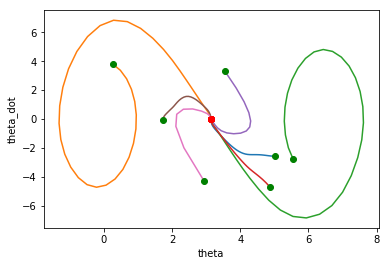

total cost:  3898.08 + ( 0.00) | 	constraint  340.00 	bad 78,  0.00 + ( 106.47)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.09639811516
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.01329612732
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.1361041069
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.31940889359
 4 5RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.75815582275
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.89060401917
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.50902700424
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.48986792564
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.29933094978
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.91548085213
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.13152503967
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.604

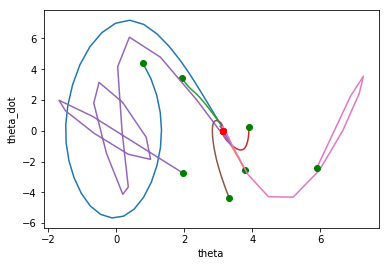

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.40284490585
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.66929197311
RESULT: SolutionResult.kInfeasibleConstraints TOTAL ELAPSED TIME: 5.86760497093
total cost:  1398.72 + ( 0.00) | 	constraint  246.45 	bad 73,  0.00 + ( 73.66)
 1 2 3

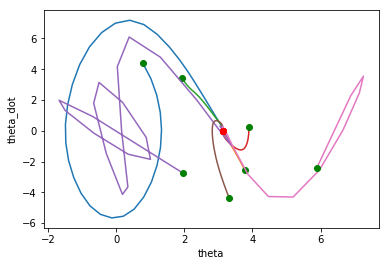

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.76583313942
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.44973707199
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.90600800514
total cost:  1398.94 + ( 0.00) | 	constraint  242.24 	bad 72,  0.00 + ( 69.83)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.70143890381
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.32604193687
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.61451196671
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.50476789474
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.83362317085
FINISHED iteration!

BEFORE NN MERGE


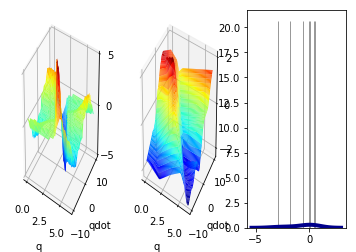

nn - vi policy deviations: avg=-0.61, std=1.20, MSE=12.63, MAE=0.91

AFTER NN MERGE


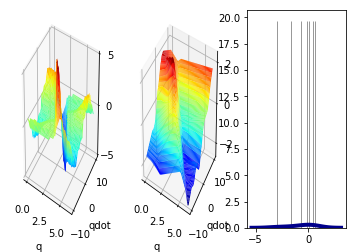

nn - vi policy deviations: avg=-0.60, std=1.20, MSE=12.59, MAE=0.95
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.82565593719
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.41961598396
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.60062909126
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.38431811333
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.32573699951
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.81226301193
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.98790216446
 0

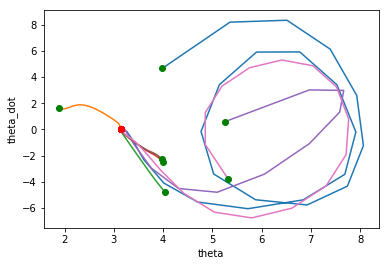

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.17192387581
total cost:  1010.95 + ( 0.00) | 	constraint  204.78 	bad 88,  0.00 + ( 53.35)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.73176813126
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.42252516747
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.81219100952
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.57272100449
 1 2 3

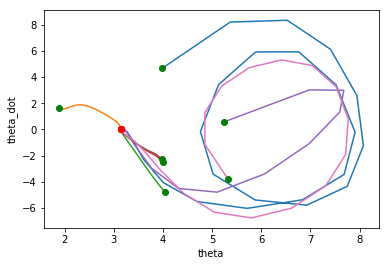

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.33219003677
total cost:  1011.35 + ( 0.00) | 	constraint  199.05 	bad 62,  0.00 + ( 45.93)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.50471806526
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.65501904488
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.59701395035
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.07437610626
 0

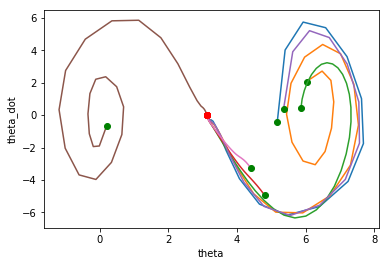

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.58018684387
total cost:  1366.87 + ( 0.00) | 	constraint  203.14 	bad 95,  0.00 + ( 50.18)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.48138213158
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.45909690857
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.01667022705
 1 2 3

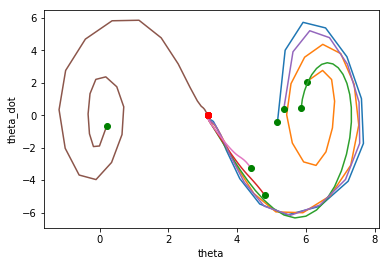

total cost:  1367.19 + ( 0.00) | 	constraint  197.09 	bad 59,  0.00 + ( 41.24)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.63404393196
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.55824494362
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.65293002129
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.95612001419
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 8.97384381294
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.54820179939
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.72212290764
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.81113004684
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.68099093437
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.43088889122
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.33352899551
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.03510

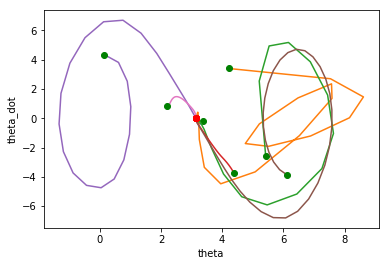

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.82224321365
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.38033604622
total cost:  1065.78 + ( 0.00) | 	constraint  200.19 	bad 100,  0.00 + ( 51.58)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.9777328968
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.01324605942
 1 2 3

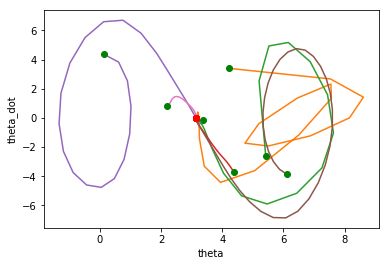

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.80790495872
total cost:  1066.26 + ( 0.00) | 	constraint  196.19 	bad 92,  0.00 + ( 47.01)
 4 5RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.52604007721
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.59309196472
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 11.910504818
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.46914601326
FINISHED iteration!

BEFORE NN MERGE


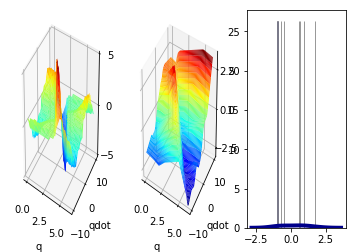

nn - vi policy deviations: avg=0.25, std=0.92, MSE=6.36, MAE=0.87

AFTER NN MERGE


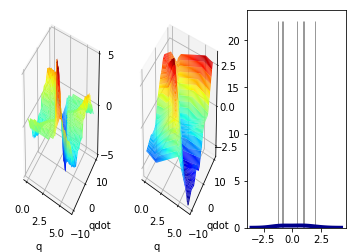

nn - vi policy deviations: avg=0.18, std=1.12, MSE=8.96, MAE=1.04
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.06486582756
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.6754090786
 0

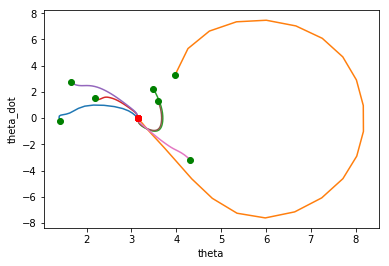

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.99715685844
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.58550190926
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.16316819191
total cost:  2607.08 + ( 0.00) | 	constraint  296.88 	bad 96,  0.00 + ( 83.01)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.73267102242
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.76855707169
 1 2 3

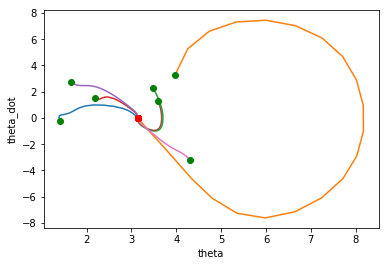

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.29170894623
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.67722606659
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.54125094414
total cost:  2608.03 + ( 0.00) | 	constraint  292.63 	bad 95,  0.00 + ( 79.07)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.79434895515
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.80723285675
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 7.297508955
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.6012198925
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.58826112747
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.366065979
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 0.681490182877
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.44414997101
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.368731975

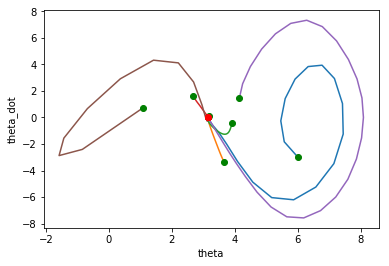

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.28387403488
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.44804286957
total cost:  773.66 + ( 0.00) | 	constraint  166.16 	bad 89,  0.00 + ( 41.29)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.91806507111
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.45411109924
 1 2 3

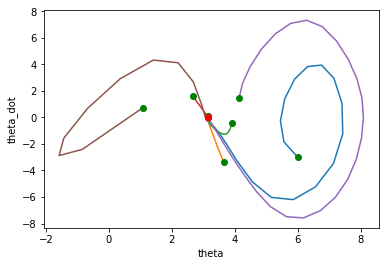

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.0027718544
total cost:  774.01 + ( 0.00) | 	constraint  162.35 	bad 86,  0.00 + ( 37.49)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.44590806961
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.71169996262
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.70396900177
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.59082603455
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.29768705368
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.45657086372
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.13480091095
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.73280787468
 0

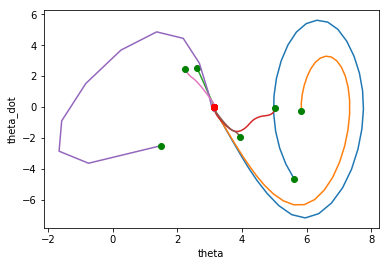

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.41282296181
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.99477601051
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.30802893639
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.39393401146
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.74762201309
total cost:  1833.15 + ( 0.00) | 	constraint  247.57 	bad 88,  0.00 + ( 63.50)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.57549881935
 1 2 3

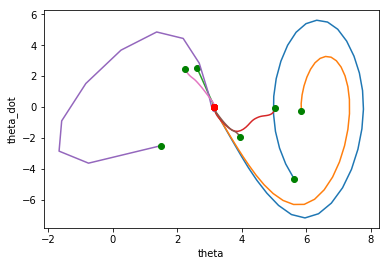

total cost:  1836.28 + ( 0.00) | 	constraint  246.21 	bad 88,  0.00 + ( 62.35)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.26388120651
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.23138618469
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.57349205017
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.34973907471
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.56693601608
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.66574621201
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.38062906265
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.84815692902
FINISHED iteration!

BEFORE NN MERGE


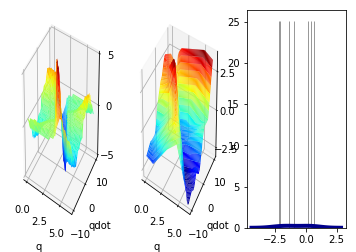

nn - vi policy deviations: avg=-0.77, std=1.10, MSE=12.59, MAE=1.11

AFTER NN MERGE


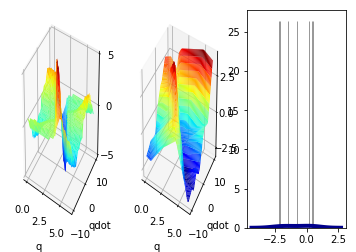

nn - vi policy deviations: avg=-0.77, std=1.07, MSE=12.16, MAE=1.08
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.73987007141
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.14532899857
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.15183401108
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.46296811104
 0

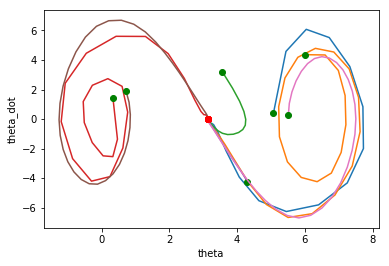

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.49490189552
total cost:  2117.65 + ( 0.00) | 	constraint  193.44 	bad 94,  0.00 + ( 46.44)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.0609998703
 1 2 3

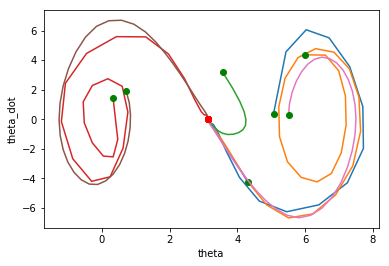

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.3964099884
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.61134195328
total cost:  2124.67 + ( 0.00) | 	constraint  190.16 	bad 86,  0.00 + ( 42.63)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.81778502464
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.3956348896
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.47073912621
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 9.26204299927
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.48388504982
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 14.3114299774
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.48862195015
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.65570902824
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.08420395851
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.2604849

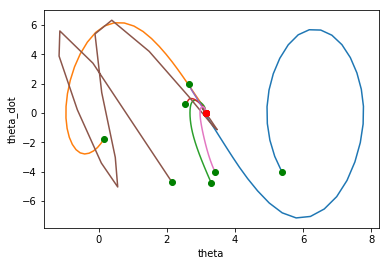

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.45200204849
total cost:  1255.94 + ( 0.00) | 	constraint  250.43 	bad 95,  0.00 + ( 63.35)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.09428501129
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.206635952
 1 2 3

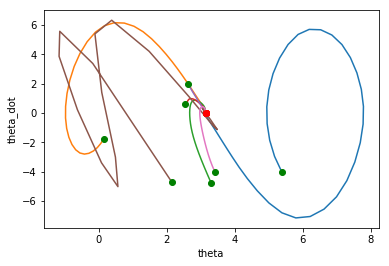

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.0796020031
total cost:  1257.75 + ( 0.00) | 	constraint  245.42 	bad 94,  0.00 + ( 59.23)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.7379732132
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.84958600998
 4 5RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.4605948925
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.69180011749
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.29039502144
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.30625486374
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 13.5729310513
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.73184490204
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.36682295799
 0

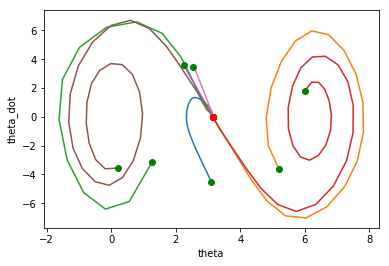

total cost:  1409.91 + ( 0.00) | 	constraint  214.88 	bad 87,  0.00 + ( 51.75)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.27585196495
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.50735497475
 1 2 3

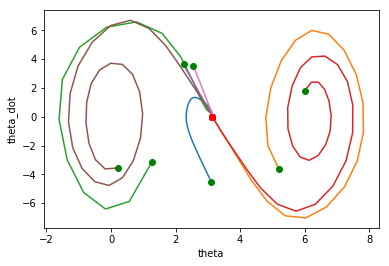

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.78149223328
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.06670403481
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.88519477844
total cost:  1411.28 + ( 0.00) | 	constraint  208.11 	bad 84,  0.00 + ( 45.27)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.14603495598
 4 5RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.80307006836
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.78012013435
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 9.85323095322
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.5367231369
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.41179203987
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.5142288208
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.58470010757
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.47248101234
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.360

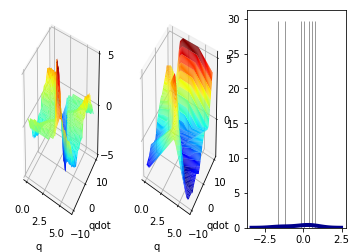

nn - vi policy deviations: avg=-0.18, std=0.84, MSE=5.17, MAE=0.67

AFTER NN MERGE


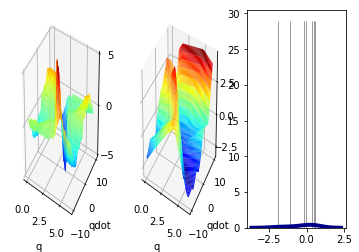

nn - vi policy deviations: avg=-0.26, std=0.86, MSE=5.65, MAE=0.67
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.08423709869
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.93387317657
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.85992693901
 0

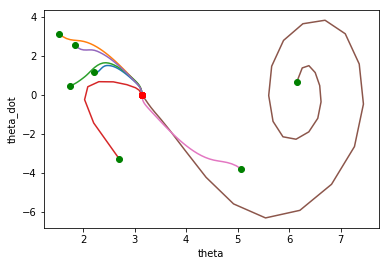

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.38152813911
total cost:  2670.65 + ( 0.00) | 	constraint  294.15 	bad 100,  0.00 + ( 63.52)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.56028103828
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.19209289551
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.03006911278
 1 2 3

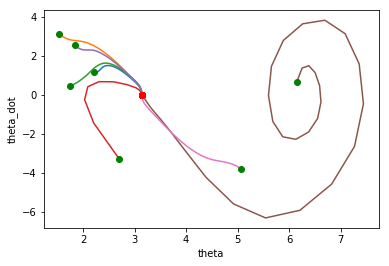

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 6.45721793175
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.67283296585
total cost:  2672.72 + ( 0.00) | 	constraint  290.03 	bad 100,  0.00 + ( 59.74)
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.99874711037
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.05647301674
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.89848089218
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.55446887016
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.375882864
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.31977391243
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.73101687431
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.22626495361
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.30708312988
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.587229

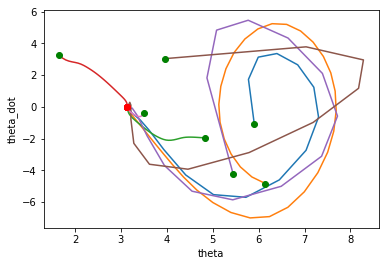

RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.786495924
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.8779501915
total cost:  1293.68 + ( 0.00) | 	constraint  225.24 	bad 88,  0.00 + ( 50.69)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.3115260601
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.48792505264
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.60422587395
 1 2 3

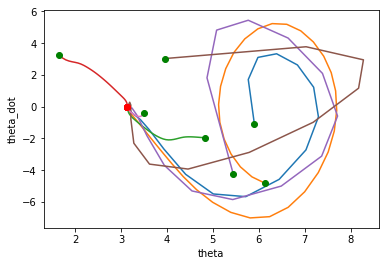

total cost:  1294.81 + ( 0.00) | 	constraint  223.41 	bad 88,  0.00 + ( 49.14)
 4 5 6

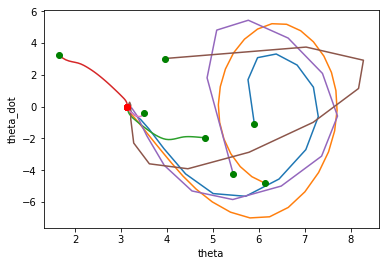

total cost:  1296.40 + ( 0.00) | 	constraint  221.72 	bad 87,  0.00 + ( 47.65)
 7 8RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.14702486992
FINISHED iteration!

BEFORE NN MERGE

AFTER NN MERGE
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.34783101082
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.18451309204
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.14364600182
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.41194701195
 0

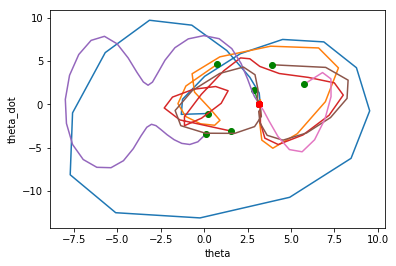

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.8700067997
total cost:  4312.60 + ( 0.00) | 	constraint  177.65 	bad 97,  0.00 + ( 59.77)
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 5.69421005249
 1 2 3

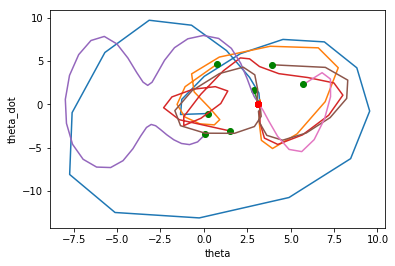

RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 7.75856900215
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.80679416656
total cost:  4314.17 + ( 0.00) | 	constraint  170.04 	bad 96,  0.00 + ( 52.23)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.43726682663
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.62051582336
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 8.99898409843
 4RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.85835886002
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.42745089531
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.34026288986
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.36145591736
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 5.28676891327
FINISHED iteration!

BEFORE NN MERGE


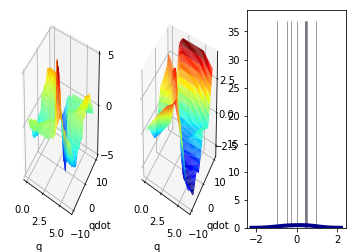

nn - vi policy deviations: avg=0.02, std=0.61, MSE=2.64, MAE=0.52

AFTER NN MERGE


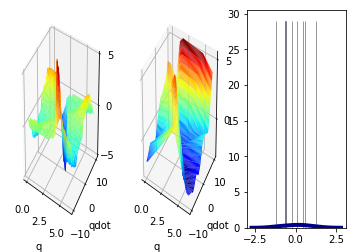

nn - vi policy deviations: avg=0.05, std=0.76, MSE=4.03, MAE=0.63
began iteration!
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.08139610291
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.08746790886
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 4.36750817299


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function, absolute_import

import copy
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

from multiple_traj_opt import *
from nn_system.networks import *
from traj.vi_utils import *

from pydrake.examples.pendulum import PendulumPlant

# ALWAYS PUT TORCH INPUTS LAST!! - weird antagonistic behavior 
# if put before multiple_traj_opt.py
import torch
from torch.nn.init import *

# So that my print statements don't get weirdly interleaved!
old_print = print
def print(*args, **kwargs):
    flush = kwargs.pop('flush', False)
    old_print(*args, **kwargs)
    if flush:
        file = kwargs.get('file', sys.stdout)
        # Why might file=None? IDK, but it works for print(i, file=None)
        file.flush() if file is not None else sys.stdout.flush()
        
import functools
print = functools.partial(print, flush=True)
import time
import csv

##### RUSS'S MINIBATCH METHOD
import sys
seed = 1776; np.random.seed(seed); torch.manual_seed(seed)


########################################################
# This is where I'm going to put the settings for all 
# of my sweeps!
########################################################

######################################################
################# Defaults
# N = 6
N = int( multiprocessing.cpu_count() * 4 / 5 )
num_trajectories = 7
def kNetConstructor():
    return MLP(n_inputs=2, h_sz=12)
def method_getter(iter_count):
    return (method4 if iter_count == 0 else method1)
warm_start = True # Will do linear?
ic_gen = lambda: initial_conditions_random(num_trajectories, (0, 2*math.pi), (-5, 5))
ic_lists_static = [ic_gen() for _ in range(N)]
def make_ic_lists(iter_count):
    return ic_lists_static


######################################################
################# None
# fname = "MTO_pend.csv"


######################################################
################# Dropout
# fname = "MTO_pend_dropout.csv"
# def kNetConstructor():
#     return MLP(n_inputs=2, h_sz=12, dropout=True)


######################################################
################# Init
# fname = "MTO_pend_init.csv"
# def kNetConstructor():
#     return MLP(n_inputs=2, h_sz=12, init = kaiming_uniform_)


######################################################
################# Noise
# fname = "MTO_pend_input_noise.csv"
# def kNetConstructor():
#     return MLP(n_inputs=2, h_sz=12, input_noise=0.1)

# fname = "MTO_pend_output_noise.csv"
# def kNetConstructor():
#     return MLP(n_inputs=2, h_sz=12, output_noise=0.1)

# fname = "MTO_pend_both_noise.csv"
# def kNetConstructor():
#     return MLP(n_inputs=2, h_sz=12, input_noise=0.1, output_noise=0.1)


######################################################
################# Minibatching
fname = "MTO_pend_minibatching.csv"
def method_getter(iter_count):
    return (method4 if iter_count == 0 else method4) #TODO
def make_ic_lists(iter_count):
    return [ic_gen() for _ in range(N)] # Actually gen fresh ic's each iteration.


######################################################
################# Warm Starting
# method0 = completely fresh
# method1 = copy exactly
# metho4 = warm start with an unconstrained traj solve

# fname = "MTO_pend_no_warm_start.csv"
# def method_getter(iter_count):
#     return (method0 if iter_count == 0 else method1) #TODO
# warm_start = False

# fname = "MTO_pend_linear_warm_start.csv"
# def method_getter(iter_count):
#     return (method0 if iter_count == 0 else method1) #TODO
# warm_start = True



################# Pruning
# fname = "MTO_pend_pruned_warm_starts"
# TODO


# csv stuff
root_dir = "sweep_csvs/"
HEADER = ["time", "itr", "avg", "std", "MSE", "MAE"]
def write_header():
    with open(root_dir+fname, mode='w') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(HEADER)
def write_row(time, itr, avg, std, MSE, MAE):
    with open(root_dir+fname, mode='a') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([time, itr, avg, std, MSE, MAE])
write_header()

vi_policy, _ = load_policy("good", "pendulum")

########################################
# MACHINERY FOR PARALLELISM

def parallel_helper(inp):
    (method, packed_mto, ic_list, kwargs) = inp
    mto = unpack_mto(*packed_mto)
    
#     print("{} doing method".format(kwargs["i"]))
    old_mto, new_mto = method(mto, ic_list, **kwargs)
#     print("{} FINISHED method".format(kwargs["i"]))
    
    packed_old_mto = pack_mto(old_mto)
    packed_new_mto = pack_mto(new_mto)

    return packed_old_mto, packed_new_mto

def do_parallel(method, mtos, ic_lists, **kwargs):
    from pathos.multiprocessing import ProcessingPool as Pool
#     from multiprocessing import Pool
    p = Pool(N)
    inputs = []
    for i, (mto, ic_list) in enumerate(zip(mtos, ic_lists)):
        kwargs_copy = copy.deepcopy(kwargs)
        
        # Disable all but the first visualization stream when running parallel
        kwargs_copy['i'] = i
        if i != 0: 
            kwargs_copy["vis_cb_every_nth"] = None
            kwargs_copy["cost_cb_every_nth"] = None
            
        # Pack the mto so it doesn't give pickle/copy complaints
        packed_mto = pack_mto(mto)
        inputs.append((method, packed_mto, ic_list, kwargs_copy))

    results = p.map(parallel_helper, inputs)

    results = [(unpack_mto(*packed_old_mto), unpack_mto(*packed_new_mto) )
                    for (packed_old_mto, packed_new_mto) in results]
    old_mtos, new_mtos = zip(*results)
    return old_mtos, new_mtos

old_mtos = [None]*N
new_mtos = [None]*N
iter_count = 0
TOTAL_ITERATIONS = 100
while iter_count < TOTAL_ITERATIONS:
    ic_lists = make_ic_lists(iter_count)
    print("began iteration!")
    method = method_getter(iter_count)
#     old_mtos[0], new_mtos[0] = method4(new_mtos[0], ic_list,
    old_mtos, new_mtos = do_parallel(method, new_mtos, ic_lists, 
                              num_trajectories=num_trajectories,
                              expmt = "pendulum",
                              kNetConstructor=kNetConstructor,
                              use_constraint=True,
                              cost_factor=None, # Was 25.
                              vis_cb_every_nth=3, 
                              cost_cb_every_nth=3, 
                              seed=None,
                              warm_start=warm_start,
                              snopt_overrides=[('Time limit (secs)',  5.),
                                               ('Major step limit',  0.005),
#                                                ('Linesearch tolerance', 0.99), # Recommended in the case of all known gradients.
#                                                ('Derivative linesearch', True)
                                              ])
    print("FINISHED iteration!")

    def vis_old_new_mto_pair(old_mto, new_mto):
        # Print learned policy vs vi_policy here (only possible for state dim == 2)
        net = new_mto.create_net(from_initial_guess=(N>1)) # b/c of our weird ass pickling HACK
        net.eval()
        fig = plt.figure()
        ax1 = fig.add_subplot(131, projection='3d')
        ax2 = fig.add_subplot(132, projection='3d')
        ax3 = fig.add_subplot(133)
        if new_mto.expmt == "pendulum":
            vis_vi_policy(vi_policy, ax1)
            vis_nn_policy_like_vi_policy(net, vi_policy, ax2)

        # Print Divergence metrics between the two policies
        results = []
        if new_mto.expmt == "pendulum":
            test_coords = initial_conditions_random(100000, (0, 2*math.pi), (-5, 5))
        elif new_mto.expmt == "cartpole":
            test_coords = initial_conditions_random_all_dims(100000, ((-3., 3.), (0., 2*math.pi), (-1., 1.), (-1., 1.)) )
        test_coords = ic_lists[0]
        for coord in test_coords:
            pair = (eval_vi_policy(coord, vi_policy), eval_nn_policy(coord, net))
            results.append(pair)
        diffs = [result[1] - result[0] for result in results]
        avg, std, MSE, MAE = plot_and_print_statistics(diffs, "nn - vi policy deviations", bins=500, xlim=None, ax=ax3)
        
        write_row(time.time(), iter_count, avg, std, MSE, MAE)
    
    DISPLAY_ALL = False
    print("\nBEFORE NN MERGE")
    for i, (old_mto, new_mto) in enumerate(zip(old_mtos, new_mtos)):
        if (i == 0 or DISPLAY_ALL) and iter_count % 3 == 0 and i % 10 == 0:
            vis_old_new_mto_pair(old_mto, new_mto)

    # Do NN Merge here!
    all_T_params = [new_mto.prog.GetInitialGuess(new_mto.T) for new_mto in new_mtos]
    a_size = all_T_params[0].shape
    avg_T_params = np.sum(np.vstack(all_T_params), axis=0)/N
    STEP_SIZE = 1.0
    for new_mto in new_mtos:
        new_T_params = all_T_params[i] + STEP_SIZE*(avg_T_params - all_T_params[i])
        new_mto.prog.SetInitialGuess(new_mto.T, new_T_params)
    
    DISPLAY_ALL = False
    print("\nAFTER NN MERGE")
    for i, (old_mto, new_mto) in enumerate(zip(old_mtos, new_mtos)):
        if (i == 0 or DISPLAY_ALL) and iter_count % 3 == 0:
            vis_old_new_mto_pair(old_mto, new_mto)
            
#     for i, new_mto in enumerate(new_mtos):
#         print(i, new_mto.prog.GetInitialGuess(new_mto.T))

    iter_count += 1

        

In [ ]:
# Could easily make a utility that puts all plots side by side here...












## ----------------------------------------- Visualizations below this line --------------------------------------

In [ ]:
#### Get a sense of the consistency of x and u!
# Let's plot all the u's on the z axis and x (theta, theta_dot) on the y and x axes...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = [], [], []
for ti in range(new_mto.num_trajectories):
    h_sol  = new_mto.prog.GetSolution(new_mto.h[ti])[0]
    print(h_sol)

    t_s = [h_sol*i for i in range(new_mto.num_samples)]
    x_s  = new_mto.prog.GetSolution(new_mto.x[ti])
    u_s    = new_mto.prog.GetSolution(new_mto.u[ti])
    x_trajectory = PiecewisePolynomial.Cubic(t_s, x_s, False)
#     t_samples = np.linspace(breaks[0], breaks[-1], 100) 
#     x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])
    thetas, theta_dots = zip(*x_s)
    print(thetas, theta_dots, u_s)
    xs += thetas
    ys += theta_dots
    zs += u_s
print(list((len(thing) for thing in (xs, ys, zs))))
ax.scatter(xs, ys, zs, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


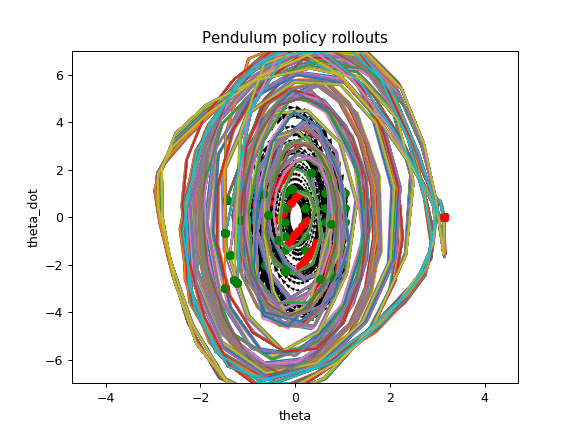

In [28]:
import math
ic_list = initial_conditions_grid(36, (-math.pi/3, math.pi/3), (-5/3, 5/3))
new_mto.plot_all_policies("state_quiver", ic_list)

In [ ]:
from nn_system.NNSystemHelper import create_nn
kNetConstructor = lambda: FCBIG(2)
nn = create_nn(kNetConstructor, list(new_mto.prog.GetSolution(new_mto.T)))
list(nn.parameters())

In [ ]:
ti = 0
mto.render_policy(ti)

<IPython.core.display.Javascript object>


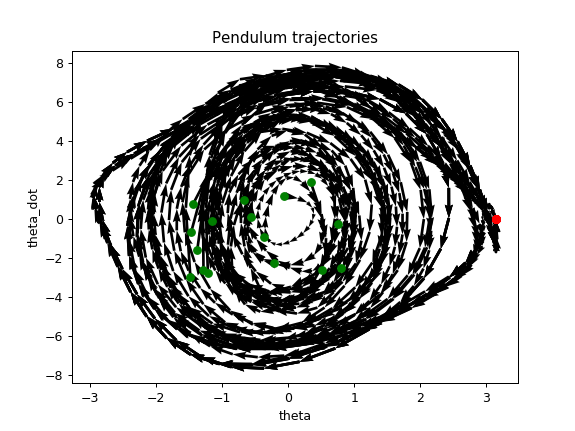

In [27]:
# mto.plot_all_trajectories("state_scatter")
new_mto.plot_all_trajectories("state_quiver")
# mto.plot_all_trajectories("tip_scatter")
# mto.plot_all_trajectories("tip_quiver")

### Visualize the found trajectories

In [ ]:
ti = 0
mto.plot_single_trajectory(ti, "state_scatter")
mto.plot_single_trajectory(ti, "state_quiver")
mto.plot_single_trajectory(ti, "tip_scatter")
mto.plot_single_trajectory(ti, "tip_quiver")

mto.render_single_trajectory(ti)